# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
В этом ноутбуке реализованы следующие шаги:
1. Проведен EDA:
    - проведен анализ датасетов (количество пропусков, количество уникальных значений и т.п.)
    - проведен анализ признаков (присутствие дубликатов, распределение значений признаков и т.п.)
    - проведен корреляционный анализ (взаимная корреляция признаков, корреляция признаков с целевой переменной)
2. Добавлены новые признаки (такие как износ машины, возраст модели и т.п.)
3. Датасеты переработы по условиям, полученным из первых двух пунктов:
    - убраны дублирующие друг друга признаки
    - из некоторых категориальных признаков извлечены признаки числовые
    - проведена нормализация признаков
4. Обработан признак "описание модели" с целью  подготовить признак для работы NLP моделей
5. Проведена аугментация "картинок"
6. На полученном датасете обучены модели и сделаны предсказания:
    - наивная модель
    - CatBoost и LightAutoML для работы с табличными данными
    - Нейросеть для работы с табличными данными
    - NLP и multiple inputs модели
    - mulitple inputs модель, обрабатывающая одновременно табличные данные, текстовые данные и картинки
    - проведен блендинг
    - проведен "проброс признака"
7. Были использованы transfer-learning, fine tuning, управление learning rate

В __выводах__ - несколько слов о том, что получилось и чего не получилось сделать (и почему).

__Важный момент__ все предсказания дополнительно обрабатывались. Так как цены в датасете представлены кратными 10000 р, все предсказания (для вычисления MAPE и для сабмита на Kaggle) приводились к такому же виду.

In [1]:
# !pip install -q tensorflow == 2.3

In [2]:
# аугментации изображений
# !pip install albumentations -q

In [3]:
# импортируем необходимые библиотеки

import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

# plt
import seaborn as sns
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
# функция ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Видим, что в признаке "Владение" 2/3 значений пропущено, Думаю, что его можно (и нужно) удалить. В признаке "Владельцы" есть один пропуск. Чуть позже подумаю как и чем его можно заполнить. 

In [11]:
# просто для "интереса" посмотрю сколько уникальных значений в каждом из признаков.
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [12]:
test['brand'].value_counts(normalize=True)

BMW         0.436864
MERCEDES    0.330341
AUDI        0.232795
Name: brand, dtype: float64

In [13]:
train['brand'].value_counts(normalize=True)

BMW         0.419784
MERCEDES    0.343310
AUDI        0.236905
Name: brand, dtype: float64

Как видим, в тестовом и трейновом датасетах присутствуют одни и те же марки авто. Можно приступать к работе.

# Создадим "наивную" модель 
_Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели._

In [14]:
# split данных
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [15]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

In [16]:
# заполним ненайденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 10000) * 10000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.81%


# EDA

In [17]:
# Зададим пару функций

def box(col):
    sns.set(style="white")
    plt.figure(figsize=(9, 5))
    plt.title('Взаимосвязь цены и переменной ' + col, fontsize=18)
    sns.boxplot(x="price", y=col, data=train, palette='rainbow')

*На примере трйенового датасета посмотрим на признаки, их распределение, их взаимную корреляцию и корреляцию с ценой (наш таргет), кроме того посмотрим какие дополнительные признаки можно придумать, исходя из имеющихся.*

#### bodyType

In [18]:
# посмотрим какие есть уникальные значения и нет ли среди них фактически дублирующихся
train.bodyType.unique()

array(['седан', 'лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.',
       'минивэн', 'универсал 5 дв.', 'купе-хардтоп', 'купе', 'кабриолет',
       'родстер', 'хэтчбек 3 дв.', 'компактвэн', 'пикап двойная кабина',
       'внедорожник открытый', 'седан 2 дв.', 'внедорожник 3 дв.',
       'лимузин'], dtype=object)

Оказалось, что фактические дубликаты есть. Например, 'хэтчбек 5 дв.' и 'хэтчбек 3 дв.'. Можно заменить все это на просто "хэтчбек", так как инфоформация о количестве дверей есть в отдельном признаке.

Итак, заменю 'хэтчбек 5 дв.' и 'хэтчбек 3 дв.' на "хэтчбек"; 'внедорожник 5 дв.' и 'внедорожник 3 дв.' на "внедорожник" ("внедорожник открытый" не буду трогать, так как это уникальная информация о типе кузова, нигде более не дублирующаяся)

In [19]:
for i in range(len(train)):
    if train.bodyType.iloc[i] == 'внедорожник 5 дв.':
        train.bodyType.iloc[i] = 'внедорожник'
    elif train.bodyType.iloc[i] == 'внедорожник 3 дв.':
        train.bodyType.iloc[i] = 'внедорожник'
    elif train.bodyType.iloc[i] == 'хэтчбек 5 дв.':
        train.bodyType.iloc[i] = 'хэтчбек'
    elif train.bodyType.iloc[i] == 'хэтчбек 3 дв.':
        train.bodyType.iloc[i] = 'хэтчбек'
    elif train.bodyType.iloc[i] == 'седан 2 дв.':
        train.bodyType.iloc[i] = 'седан'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [20]:
# посмотрим, что получилось
train.bodyType.unique()
#  отлично! очевидных дублей нет

array(['седан', 'лифтбек', 'внедорожник', 'хэтчбек', 'минивэн',
       'универсал 5 дв.', 'купе-хардтоп', 'купе', 'кабриолет', 'родстер',
       'компактвэн', 'пикап двойная кабина', 'внедорожник открытый',
       'лимузин'], dtype=object)

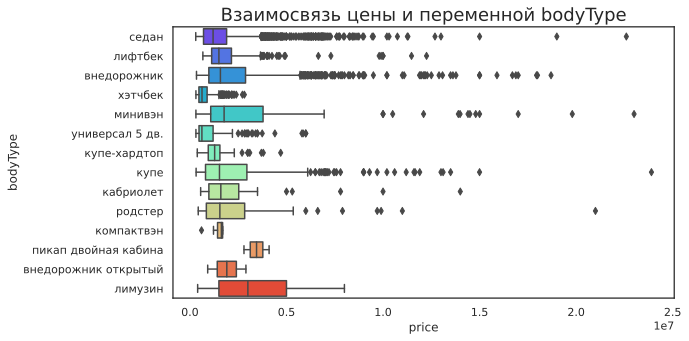

In [21]:
box('bodyType')

Из диаграммы вино, что в среднем тип кузова не слишком сильно влияет на уровень цены. Да, средняя цена на лимузыины выше, но есть более распространенная модель "седан" или "купе", которые в пиковых значениях существенно лимузины превосходят (впрочем, сомневаюсь, что лимузины продают на вторичном рынке через сайты типа Авто.Ру)

#### brand

In [22]:
train.brand.unique()

array(['BMW', 'AUDI', 'MERCEDES'], dtype=object)

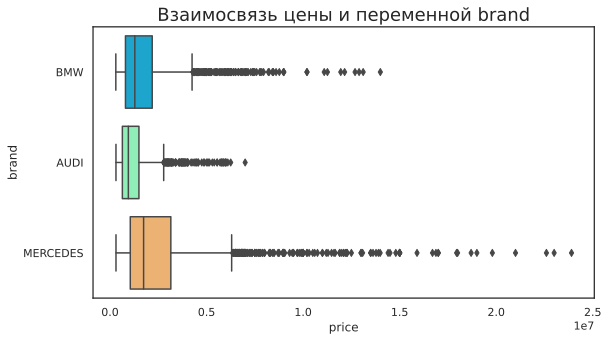

In [23]:
box('brand')

В датасетах представлено всего три марки авто (выше видели, что они представлены в обоих датасетах и представлены примерно одинаково). Видим, что цена на Мерседес выше

#### color

In [24]:
train.color.unique()
# очевидных дублей нет

array(['чёрный', 'серебристый', 'белый', 'синий', 'серый', 'красный',
       'коричневый', 'зелёный', 'голубой', 'пурпурный', 'бежевый',
       'фиолетовый', 'оранжевый', 'золотистый', 'жёлтый', 'розовый'],
      dtype=object)

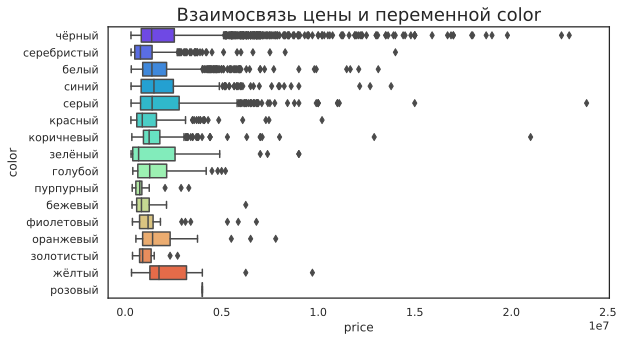

In [25]:
box('color')

У автомобилей черного цвета большее количество автомобилей с высокой ценой

#### description

С этим признаком буду работать позднее в соответвующем разделе ноутбука (буду чистить текст, токенизировать и т.п.), сейчас его просто пропустим.

#### engineDisplacement

In [26]:
train.engineDisplacement.unique()

array(['3.0 LTR', '2.8 LTR', '3.5 LTR', '2.0 LTR', '1.8 LTR', '5.5 LTR',
       '2.5 LTR', '1.6 LTR', '1.5 LTR', '4.8 LTR', '4.4 LTR', '3.8 LTR',
       '2.2 LTR', '4.0 LTR', '2.1 LTR', '2.4 LTR', '4.7 LTR', '1.2 LTR',
       '3.6 LTR', '3.1 LTR', '0.7 LTR', '6.0 LTR', '4.1 LTR', '5.0 LTR',
       '5.4 LTR', '6.2 LTR', '4.2 LTR', '1.4 LTR', '2.9 LTR', '1.7 LTR',
       '3.2 LTR', '2.7 LTR', '1.9 LTR', '1.3 LTR', '5.2 LTR', '3.7 LTR',
       '5.9 LTR', '4.9 LTR', '2.3 LTR', '6.6 LTR', '3.4 LTR', '6.3 LTR',
       '2.6 LTR', 'undefined LTR', '5.6 LTR', '4.3 LTR', '4.6 LTR',
       '5.8 LTR'], dtype=object)

Очевидно, что эта информация содержит числовые значения (объем двигателя). Вынуть эту информацию не сложно. 

In [27]:
train.engineDisplacement = train.engineDisplacement.apply(
    lambda x: float(x.replace(' LTR', '')) if x != 'undefined LTR' else x)

У нас осталось значение 'undefined LTR'. Это электромобили, у которых действительно нет понятия объема двигателя. Можно заменить это, посмотрев на мощность двигателя и подобрав наиболее характерный для такой мощности объем, но сейчас я этого делать не буду. В дальнейшем я буду избавляться от этого признака, так как он сильно скоррелирован как раз с признаком мощности двигателя. 

#### enginePower

In [28]:
train.enginePower.unique()

array(['272 N12', '204 N12', '306 N12', '180 N12', '160 N12', '184 N12',
       '197 N12', '326 N12', '190 N12', '245 N12', '224 N12', '585 N12',
       '211 N12', '225 N12', '218 N12', '156 N12', '231 N12', '238 N12',
       '140 N12', '150 N12', '360 N12', '122 N12', '555 N12', '249 N12',
       '95 N12', '136 N12', '163 N12', '407 N12', '469 N12', '388 N12',
       '544 N12', '177 N12', '170 N12', '455 N12', '105 N12', '280 N12',
       '367 N12', '340 N12', '400 N12', '233 N12', '265 N12', '450 N12',
       '333 N12', '290 N12', '300 N12', '192 N12', '143 N12', '390 N12',
       '269 N12', '408 N12', '240 N12', '200 N12', '320 N12', '258 N12',
       '435 N12', '115 N12', '120 N12', '558 N12', '235 N12', '476 N12',
       '525 N12', '279 N12', '420 N12', '239 N12', '575 N12', '422 N12',
       '507 N12', '193 N12', '605 N12', '116 N12', '271 N12', '220 N12',
       '310 N12', '102 N12', '355 N12', '350 N12', '210 N12', '82 N12',
       '462 N12', '125 N12', '313 N12', '557 N12', '2

In [29]:
# извлечем численные значения признака
train.enginePower = train.enginePower.apply(
    lambda x: float(x.replace(' N12', '')))

In [30]:
# посмотрим, что получилось
train.enginePower.unique()

array([272., 204., 306., 180., 160., 184., 197., 326., 190., 245., 224.,
       585., 211., 225., 218., 156., 231., 238., 140., 150., 360., 122.,
       555., 249.,  95., 136., 163., 407., 469., 388., 544., 177., 170.,
       455., 105., 280., 367., 340., 400., 233., 265., 450., 333., 290.,
       300., 192., 143., 390., 269., 408., 240., 200., 320., 258., 435.,
       115., 120., 558., 235., 476., 525., 279., 420., 239., 575., 422.,
       507., 193., 605., 116., 271., 220., 310., 102., 355., 350., 210.,
        82., 462., 125., 313., 557., 264., 530., 329., 250., 510., 130.,
       194., 612., 571., 517., 335., 118., 255., 286., 110., 372., 500.,
       230., 381., 430., 560., 296., 260., 639., 550., 299., 129., 252.,
       625., 610., 401., 394., 402., 445., 316., 109., 330., 600., 292.,
       431., 354., 520., 100., 113., 242., 370., 609., 626., 457.,  75.,
       256., 347., 223., 215.,  98., 487., 270., 114., 480., 234., 514.,
       165., 174., 580.])

#### fuelType

In [31]:
train.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро'], dtype=object)

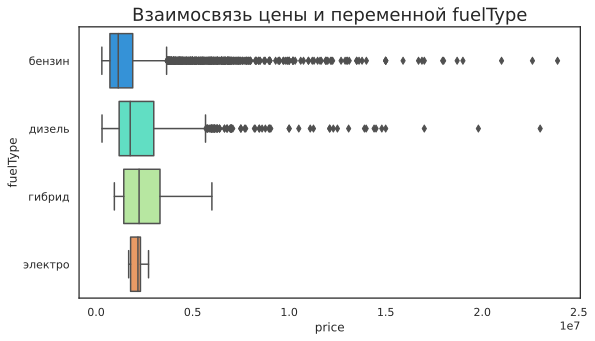

In [32]:
box('fuelType')

Очевидных дубликатов нет. Наиболее распространены автомобили с бензиновым двигателем, но максимальная средняя цена у авто с гибридным двигателем

#### mileage

In [33]:
train.mileage 

0       245000
1       183000
2       122733
3       151000
4       140000
         ...  
6677    232777
6678     33700
6679    200000
6680     72000
6681     21291
Name: mileage, Length: 6682, dtype: int64

Обработкой и оценкой численных признаков займусь позже и всеми вместе

#### model_info

In [34]:
train.model_info.unique()

array(['5ER', 'A6', 'E_KLASSE', 'A5', 'C_KLASSE', '7ER', '3ER', 'X4',
       'M_KLASSE', 'S_KLASSE_AMG', 'Q5', 'CLA_KLASSE', 'GLA_CLASS', 'X1',
       'Q7', 'X2', 'X5', 'B_KLASSE', 'X6_M', 'S_KLASSE', 'VITO', 'A3',
       '1ER', 'CLS_KLASSE', 'X6', 'S_CLASS_MAYBACH', 'CL_KLASSE',
       'G_KLASSE_AMG', 'GLC_KLASSE', 'GLS_KLASSE', 'A8', 'A4',
       'GLE_KLASSE_COUPE_AMG', 'X3', 'Q3', 'X7', 'G_KLASSE',
       'GLS_KLASSE_AMG', 'I3', 'VIANO', 'GL_KLASSE', 'V_KLASSE',
       'SLK_KLASSE', 'GLC_COUPE', 'CLS_KLASSE_AMG', 'A_KLASSE', 'S7', '4',
       'A7', '6ER', 'RS6', 'M_KLASSE_AMG', 'GLK_KLASSE', 'R_KLASSE',
       'GLE_KLASSE', 'Z4', 'A1', 'C_KLASSE_AMG', 'GLE_KLASSE_AMG',
       'GLC_KLASSE_AMG', 'Z3', 'CLK_KLASSE', 'X5_M', 'M6', 'ALLROAD',
       'SLS_AMG', 'S5', '2GRANDTOURER', 'SL_KLASSE', 'E_KLASSE_AMG',
       'W124', 'GLE_KLASSE_COUPE', 'SLC_KLASSE', 'TT', 'S8',
       'CLA_KLASSE_AMG', 'R8', 'M5', '2ER', 'RSQ3', 'S4', 'CL_KLASSE_AMG',
       'Q8', 'AMG_GT', 'GLA_CLASS_AMG', 'M4'

Это признак, указывающий на конкретную модель бренда. Важный признак. Оставим его пока в покое

####  name

In [35]:
train.name.iloc[0]

'530xi 3.0 AT (272 л.с.) 4WD'

Признак очевидно объединяет в себе несколько других - марка модели, объем двигателя, тип трансмиссии, мощность и тип привода. Будем его убирать

#### numberOfDoors

In [36]:
train.numberOfDoors.unique()

array([4, 5, 2, 3])

Теперь этот признак дополняет информацию признака bodyType

#### vehicleConfiguration

In [37]:
train.vehicleConfiguration.iloc[0]

'SEDAN AUTOMATIC 3.0'

Признак, который так же как и name дублирует несколько уже имеющихся (тип кузова, тип привода, объем двигателя). Будем удалять

#### vehicleTransmission

In [38]:
train.vehicleTransmission.unique()

array(['автоматическая', 'вариатор', 'роботизированная', 'механическая'],
      dtype=object)

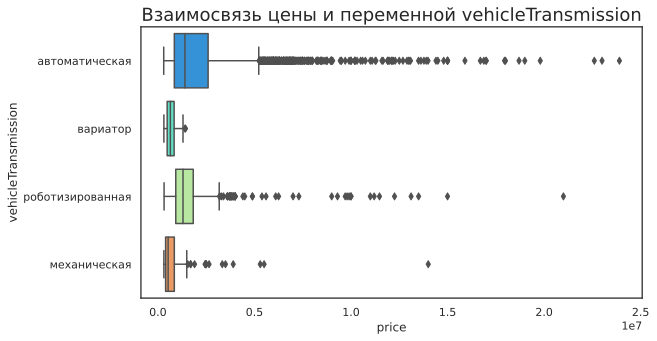

In [39]:
box('vehicleTransmission')

Автоматическая трансмиссия у авто дает шанс на лучшую цену

#### Владельцы

In [40]:
train['Владельцы'].unique()

array(['3 или более', '2\xa0владельца', '1\xa0владелец', nan],
      dtype=object)

В этом признаке у нас есть один пропуск. В последствии заменю его на "3 или более"

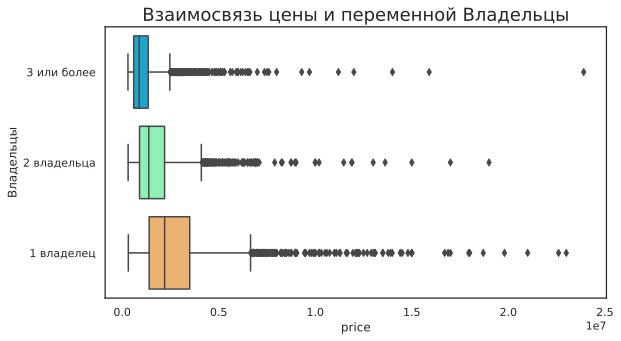

In [41]:
box('Владельцы')

Очевидно - чем меньше было у машины владельцев, тем выше ее цена на вторичном рынке

#### Владение

В этом признаке 2/3 значений пропущено (видели выше). Под удаление.

#### ПТС

In [42]:
train['ПТС'].unique()

array(['Оригинал', 'Дубликат'], dtype=object)

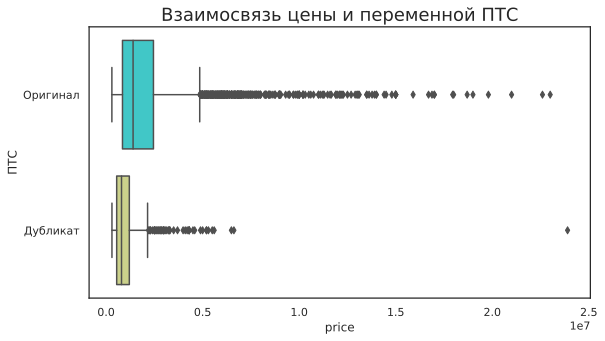

In [43]:
box('ПТС')

Еще один очевидный вывод - дубликаты ПТС снижают цену авто

#### Привод

In [44]:
train['Привод'].unique()

array(['полный', 'передний', 'задний'], dtype=object)

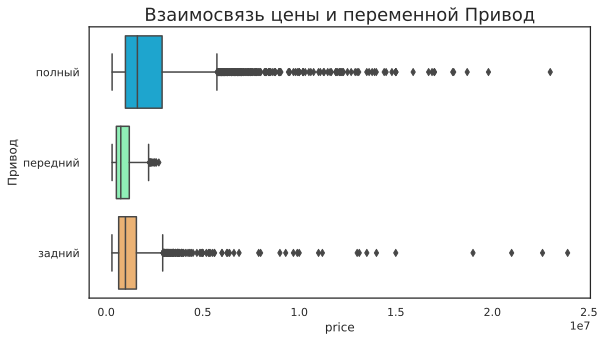

In [45]:
box('Привод')

Машины с полным приводом стоят дороже. 

#### Руль

In [46]:
train['Руль'].unique()

array(['Левый', 'Правый'], dtype=object)

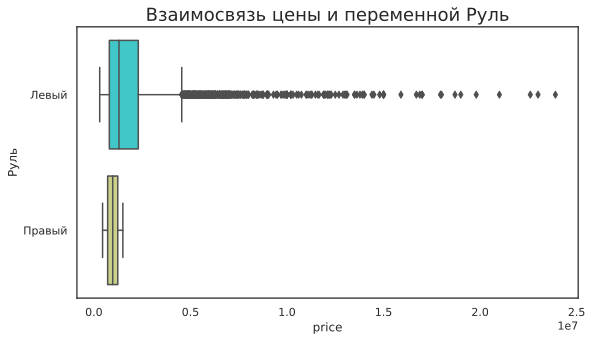

In [47]:
box('Руль')

Правый руль - дешевле машина.


### Добавим признаков

#### Посмотрим насколько стара машина

In [48]:
# (разница в годах между сегодняшней датой и годом производства)
train['how_old'] = train['productionDate'].apply(
    lambda x: pd.Timestamp.today().year - x)

#### Посмотрим на то как интенсивно использовалось авто

In [49]:
# Посмотрим насколько интенсивно использовалась машина
train['mile_per_year'] = train['mileage'] / train['how_old']

#### Посмотрим на разницу года выпуска и года "объявления" модели

In [50]:
# Посмотрим разницу между годом выпуска машины и годом начала выпуска этой модели
train['model_age'] = train['productionDate'] - train['modelDate']

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   float64
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [52]:
train.engineDisplacement = train.engineDisplacement.apply(
    lambda x: 0 if x == 'undefined LTR' else float(x))

### Время посмотреть на числовые признаки

In [53]:
train.engineDisplacement = train.engineDisplacement.apply(
    lambda x: 0 if x == 'undefined LTR' else float(x))

In [54]:
num_col = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate',
           'numberOfDoors', 'price', 'productionDate', 'how_old', 'mile_per_year', 'model_age']
# не стал включать сюда sell_id по очевидным причинам (служебная информация, под удаление)

Посмотрим, как выглядит распределение этих признаков

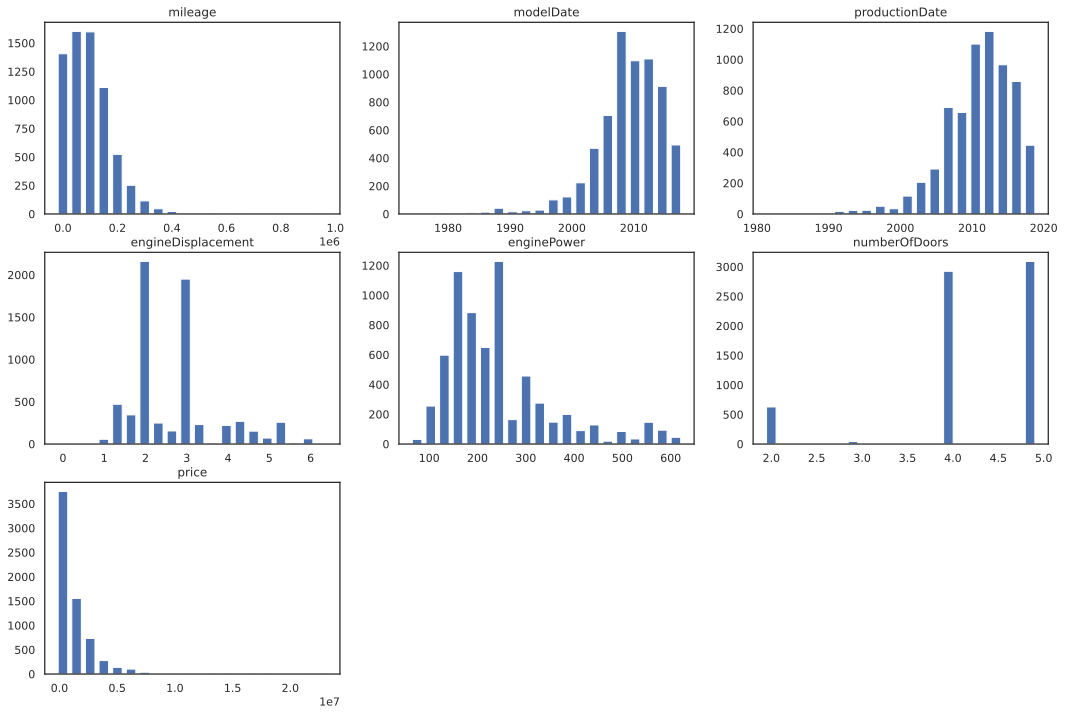

In [55]:
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': train['mileage'],
    'modelDate': train['modelDate'],
    'productionDate': train['productionDate'],
    'engineDisplacement': train['engineDisplacement'],
    'enginePower': train['enginePower'],
    'numberOfDoors': train['numberOfDoors'],
    'price': train['price']
})

Посмотрим как будет выглядеть распределение после логарифмирования

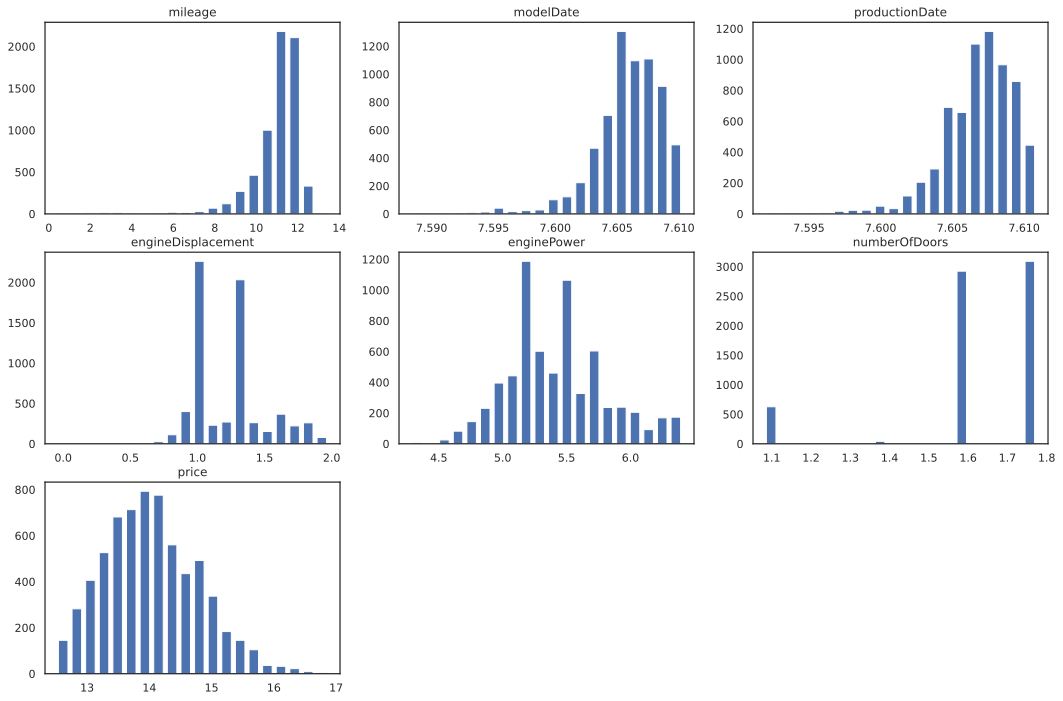

In [56]:
visualize_distributions({
    'mileage': np.log(train['mileage'] + 1),
    'modelDate': np.log(train['modelDate'] + 1),
    'productionDate': np.log(train['productionDate'] + 1),
    'engineDisplacement': np.log(train['engineDisplacement'] + 1),
    'enginePower': np.log(train['enginePower'] + 1),
    'numberOfDoors': np.log(train['numberOfDoors'] + 1),
    'price': np.log(train['price'] + 1)
})

Используем это при обработке датасета

Посмотрим на корреляцию признаков

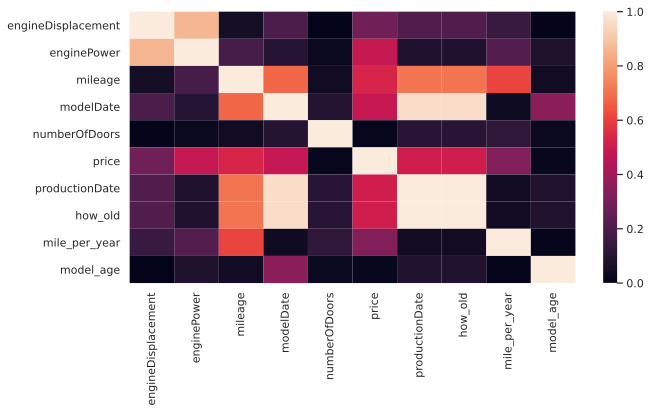

In [57]:
gg = sns.heatmap(train[num_col].corr().abs(), vmin=0, vmax=1)
gg.figure.set_size_inches(10, 5)

Видим, что есть сильная корреляция между объемом двигателя и его мощностью, между возрастом машины и датой выпуска ее, а так же между обеими этими датами и датой объявления марки машины

__Используем всю эту информацию и проведем предобработку всего датасета__

# PreProc Tabular Data

In [58]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
# загрузим заново датасеты, так как в трейн мы вносили изменения

train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# теперь объединим
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [59]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color',
                        'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission',
                        'Владельцы', 'ПТС', 'Привод', 'Руль']

# используем все числовые признаки
numerical_features = ['mileage', 'productionDate', 'how_old', 'mile_per_year',
                      'enginePower_N', 'model_age']

In [60]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки + убираем признак Владение, так как в нем 2/3 пропусков
    df_output.drop(['description', 'sell_id', 'Владение'],
                   axis=1, inplace=True)

    # убираем дубли из признака bodyType
    for i in range(len(df_output)):
        if df_output.bodyType.iloc[i] == 'внедорожник 5 дв.':
            df_output.bodyType.iloc[i] = 'внедорожник'
        elif df_output.bodyType.iloc[i] == 'внедорожник 3 дв.':
            df_output.bodyType.iloc[i] = 'внедорожник'
        elif df_output.bodyType.iloc[i] == 'хэтчбек 5 дв.':
            df_output.bodyType.iloc[i] = 'хэтчбек'
        elif df_output.bodyType.iloc[i] == 'хэтчбек 3 дв.':
            df_output.bodyType.iloc[i] = 'хэтчбек'
        elif df_output.bodyType.iloc[i] == 'седан 2 дв.':
            df_output.bodyType.iloc[i] = 'седан'

    # ################### Feature Engineering ####################################################

    # Определим возраст конкретной машины (разница в годах между сегодняшней датой и годом производства)
    df_output['how_old'] = df_output['productionDate'].apply(
        lambda x: pd.Timestamp.today().year - x)

    # Посмотрим насколько интенсивно использовалась машина
    df_output['mile_per_year'] = df_output['mileage'] / df_output['how_old']

    # Посмотрим разницу между годом выпуска машины и годом начала выпуска этой модели
    df_output['model_age'] = df_output['productionDate'] - \
        df_output['modelDate']

    # ################### Numerical Features ##############################################################

    # Сделаем числовой признак из engineDisplacement
    df_output['engineDisplacement_N'] = df_output['engineDisplacement'].apply(lambda x:
                                                                              x[:x.find(' LTR')])

    df_output['engineDisplacement_N'] = df_output['engineDisplacement_N'].apply(
        lambda x: float(x) if len(x) < 4 else 0)

    # Сделаем числовой признак из enginePower
    df_output['enginePower_N'] = df_output['enginePower'].apply(
        lambda x: int(x[:x.find(' N12')]))
    df_output.drop(['enginePower'], axis=1, inplace=True)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = np.log(df_output[column] + 1)
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    ##############################################################

    # убираем name, так как это признаки, которые агрегируют данные о приводе, объеме двигателя и прочие уже имеющиеся данные
    df_output.drop(['name', 'vehicleConfiguration'], axis=1, inplace=True)

    ##############################################################
    # убираем сильно скоррелированные между собой признаки Объем Двигателя и Мощность машины (уберем объем!), уберем год модели

    df_output.drop(['engineDisplacement', 'engineDisplacement_N',
                    'modelDate'], axis=1, inplace=True)

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

# ################### Polynomial Features ##############################################################
# Добавлением полиномиальных признаков ухудшило МАРЕ

    return df_output

In [61]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [62]:
df_preproc.sample(4)

mileage  productionDate  sample      price   how_old  mile_per_year  \
7399  0.829686        0.869500       1  1590000.0  0.418183       0.866669   
4273  0.763680        0.895626       1  3100000.0  0.366726       0.804296   
3362  0.778972        0.869500       1  3750000.0  0.418183       0.805970   
2794  0.841535        0.764868       1  1990000.0  0.569059       0.834258   

      model_age  enginePower_N  bodyType_0  bodyType_1  ...  Владельцы_0  \
7399   0.235409       0.528676           1           0  ...            1   
4273   0.470818       0.528676           1           0  ...            1   
3362   0.373114       0.919349           0           0  ...            0   
2794   0.000000       0.528676           0           0  ...            0   

      Владельцы_1  Владельцы_2  ПТС_0  ПТС_1  Привод_0  Привод_1  Привод_2  \
7399            0            0      0      1         0         0         1   
4273            0            0      0      1         0         0         1   
3362            0            1      0      1         0         0         1   
2794            0            1      0      1         0         0         1   

      Руль_0  Руль_1  
7399       1       0  
4273       1       0  
3362       1       0  
2794       1       0  

[4 rows x 186 columns]

In [63]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 186 entries, mileage to Руль_1
dtypes: float64(7), int64(1), uint8(178)
memory usage: 1.9 MB


# Split data

In [64]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [65]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 185 entries, mileage to Руль_1
dtypes: float64(7), uint8(178)
memory usage: 394.9 KB


# CatBoostRegressor

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [67]:
model = CatBoostRegressor(iterations=5000,
                          depth=10,
                          learning_rate=0.5,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          # task_type='GPU',
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6098053	test: 0.6298731	best: 0.6298731 (0)	total: 79.7ms	remaining: 6m 38s
100:	learn: 0.0925078	test: 0.1514757	best: 0.1514757 (100)	total: 1.97s	remaining: 1m 35s
200:	learn: 0.0605750	test: 0.1535840	best: 0.1514641 (101)	total: 4.01s	remaining: 1m 35s
300:	learn: 0.0421400	test: 0.1526498	best: 0.1514641 (101)	total: 6.23s	remaining: 1m 37s
400:	learn: 0.0303687	test: 0.1530085	best: 0.1514641 (101)	total: 8.29s	remaining: 1m 35s
500:	learn: 0.0218900	test: 0.1536703	best: 0.1514641 (101)	total: 10.7s	remaining: 1m 36s
600:	learn: 0.0164824	test: 0.1541006	best: 0.1514641 (101)	total: 13s	remaining: 1m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.151464064
bestIteration = 101

Shrink model to first 102 iterations.


In [68]:
test_predict_catboost = model.predict(X_test)
print(
    f"TEST mape: {(mape(y_test, ((test_predict_catboost//10000)*10000)))*100:0.2f}%")
# вспомним, что цена на машины в данном случае кратна 10000р, так что округлмм предикт

TEST mape: 15.08%


С полиномиальными признаками получилось TEST mape: 15.04%

Без них - 14,51%

# LightAutoML

Эту часть кода я выполнил в kaggle с отключенным GPU, сабмит сохранил для последующего использования в блендинге с уже включенным GPU

In [69]:
# !pip install -U lightautoml

# # Imports from our package
# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.tasks import Task

In [70]:
# Задаем параметры

# N_THREADS = 4 # threads cnt for lgbm and linear models
# N_FOLDS = 5 # folds cnt for AutoML
# RANDOM_STATE = 42 # fixed random state for various reasons
# TEST_SIZE = 0.2 # Test size for metric check
# TIMEOUT = 7200 # Time in seconds for automl run

# np.random.seed(RANDOM_STATE)

In [71]:
# from sklearn.metrics import mean_squared_log_error

# # Создаем задание
# task = Task('reg', loss = 'rmsle', metric = 'rmsle')

# # Создаем роли
# roles = {'target': 'price'}

In [72]:
# # Сплитанем данные для обучения
# tr_data, te_data = train_test_split(train_data, 
#                                      test_size=TEST_SIZE,
#                                      random_state=RANDOM_STATE)
# print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

In [73]:
# # Train AutoML
# automl = TabularAutoML(task = task, 
#                    timeout = TIMEOUT,
#                    cpu_limit = N_THREADS,
#                    #reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
#                     verbose = 1)
# oof_pred = automl.fit_predict(tr_data, roles = roles)

# # Predict on test
# test_pred = automl.predict(te_data)

In [74]:
# test_pred_full = test_pred.data[:, 0].copy().round(0)
# print(f"TEST mape: {(mape(te_data['price'].values, ((test_pred_full//10000)*10000)))*100:0.2f}%")

Итак, после использования AutoML, МАРЕ снижается с 14,51% до 12.09%

А теперь сделаем псевдолэйблинг (https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738)

In [75]:
# te_data_pseudo = te_data.copy()

# te_data_pseudo['price'] = test_pred.data[:, 0].copy().round(0)

In [76]:
#  tr_data_pseudo = pd.concat([tr_data, te_data_pseudo], axis=0)

In [77]:
# print(tr_data.shape)
# print( tr_data_pseudo.shape)

In [78]:
# oof_pred_2 = automl.fit_predict(tr_data_pseudo, roles = roles)

# # Predict on test
# test_pred_2 = automl.predict(te_data)

In [79]:
# test_pred_full_2 = test_pred_2.data[:, 0].copy().round(0)
# print(f"TEST mape: {(mape(te_data['price'].values, ((test_pred_full_2//10000)*10000)))*100:0.2f}%")

MAPE - 11.88%

Снижение за счет псевдолейблинга - 0,21% (!)


In [80]:
# te_data_pseudo = te_data.copy()

# te_data_pseudo['price'] = test_pred_2.data[:, 0].copy().round(0)

# tr_data_pseudo = pd.concat([tr_data, te_data_pseudo], axis=0)


# oof_pred_3 = automl.fit_predict(tr_data_pseudo, roles = roles)

# # Predict on test
# test_pred_3 = automl.predict(te_data)

In [81]:
# test_pred_full_3 = test_pred_3.data[:, 0].copy().round(0)
# print(f"TEST mape: {(mape(te_data['price'].values, ((test_pred_full_3//10000)*10000)))*100:0.2f}%")

МАРЕ - 11.86% 

In [82]:
# sub_predict_automl = automl.predict(X_sub).data[:, 0].copy().round(0)
# sample_submission['price'] = (sub_predict_automl//10000)*10000
# sample_submission.to_csv('/kaggle/working/autoML_submission.csv', index=False)

Сабмит на kaggle дал 12,23%

# Tabular NN

In [83]:
X_train.head(5)

mileage  productionDate   how_old  mile_per_year  model_age  \
7320  0.855429        0.764868  0.569059       0.850888   0.470818   
8037  0.705392        0.947839  0.231378       0.781122   0.373114   
4681  0.846775        0.633784  0.694135       0.803548   0.373114   
6014  0.915514        0.660027  0.672591       0.892114   0.235409   
3649  0.842142        0.817210  0.502073       0.855338   0.373114   

      enginePower_N  bodyType_0  bodyType_1  bodyType_2  bodyType_3  ...  \
7320       0.886702           0           0           0           0  ...   
8037       0.528676           1           0           0           0  ...   
4681       0.546610           0           0           0           0  ...   
6014       0.400411           0           0           0           0  ...   
3649       0.638525           0           0           0           0  ...   

      Владельцы_0  Владельцы_1  Владельцы_2  ПТС_0  ПТС_1  Привод_0  Привод_1  \
7320            1            0            0      0      1         1         0   
8037            1            0            0      0      1         0         0   
4681            0            0            1      0      1         0         0   
6014            0            0            1      0      1         1         0   
3649            1            0            0      0      1         0         0   

      Привод_2  Руль_0  Руль_1  
7320         0       1       0  
8037         1       1       0  
4681         1       1       0  
6014         0       1       0  
3649         1       1       0  

[5 rows x 184 columns]

## Simple Dense NN

In [84]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               94720     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 226,305
Trainable params: 226,305
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Собираем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [87]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Fit

In [88]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                    )

Epoch 1/500
 1/12 [=>............................] - ETA: 0s - loss: 100.0000 - MAPE: 100.0000
Epoch 00001: saving model to ../working/best_model.hdf5
12/12 [==============================] - 1s 52ms/step - loss: 99.9938 - MAPE: 99.9938 - val_loss: 99.9532 - val_MAPE: 99.9532
Epoch 2/500
11/12 [==========================>...] - ETA: 0s - loss: 99.7793 - MAPE: 99.7793
Epoch 00002: saving model to ../working/best_model.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 99.7756 - MAPE: 99.7756 - val_loss: 99.2525 - val_MAPE: 99.2525
Epoch 3/500
10/12 [========================>.....] - ETA: 0s - loss: 98.3772 - MAPE: 98.3772
Epoch 00003: saving model to ../working/best_model.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 98.2048 - MAPE: 98.2048 - val_loss: 95.8226 - val_MAPE: 95.8226
Epoch 4/500
 1/12 [=>............................] - ETA: 0s - loss: 95.7214 - MAPE: 95.7214
Epoch 00004: saving model to ../working/best_model.hdf5
12/12 [=================

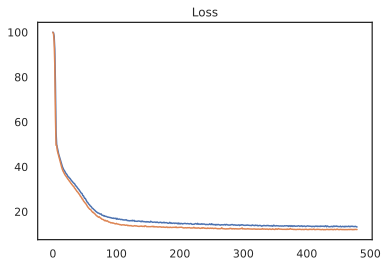

In [89]:
# посмотрим на процесс обучения модели
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [90]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [91]:
test_predict_nn1 = model.predict(X_test)
print(
    f"TEST mape: {(mape(y_test, ((test_predict_nn1[:,0]//10000)*10000)))*100:0.2f}%")

TEST mape: 12.09%


_пробовал добавить управление LR и увеличить количество слоев, но все только ухудшил_

In [92]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = (sub_predict_nn1[:,0]//10000)*10000
sample_submission.to_csv('../working/nn1_submission.csv', index=False)

Сабмит этого результата на Каггле - 12,73%

# NLP + Multiple Inputs

Для начала почистим текст в description

In [93]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [94]:
import string

In [95]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from pymystem3 import Mystem
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
words = set(nltk.corpus.words.words())

# Create lemmatizer and stopwords list
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [96]:
data1 = data.copy()

In [97]:
# посмотрим, что из себя представляет собственно текст в признаке
data1.description.iloc[0]

'Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n650 Спорт

In [98]:
# Почистим текст в признаке description
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

# Create lemmatizer and stopwords list
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

# Preprocess function


def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords
              and token != " "
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    # уберем все цифры из текста
    text = re.sub('\w*\d\w*', '', text)

    # уберем из текста все "некириллические" слова и буквы
    text = text.lower()
    letters = re.findall('[а-яА-Я\s]', text)
    text = ''.join(letters)

    return text

In [99]:
data1.description = data1.description.apply(lambda x: preprocess_text(x))

In [100]:
# просто посмотреть как изменился текст после обработки
data1.description.iloc[0]

'привет продавать эксклюзивный проект  универсал    модель     двигатель  трансмиссия  цвет кузов  черный отделка салон  кожа черный    антрацит \n опция  автоматический блокировка дифференциал   индикатор внешний температура  спортивный сидение спереди  спортивный рулевой колесо отделка кожа диаметр  мм кожаный рычаг кпп  подушка безопасность водитель передний пассажир  дополнительный бардачок вещевой отсек спереди  люк электропривод устройство подъем  автоматический коробка передача напольный исполнение  темпомат круиз контроль  автоматический антенна  двойной занавеска багажный пространство пасажирский отсек сетка шторка  складной подлокотник спереди  кондиционер  электрический стеклоподъемник передний задний дверь  атермальный боковой задний стекло задний стекло подогрев   спортивный подвеска  акб увеличивать мощность  установленный сзади динамика  электрообогрев передний кресло  исполнение  код    дополнительно установленный опция  внутренний салонный зеркало автоматический измене

In [101]:
# Зададим функцию для токенизации
def text_tokenizer(text):
    Text_ = text.strip()

    Text_ = Text_.lower()

    # Удалим все спец символы
    Text_ = remove_chars_from_text(Text_, spec_chars)

    # Удалим все цифры
    Text_ = remove_chars_from_text(Text_, string.digits)

    Text_ = Text_.replace('\n', ' ').replace('\t', ' ')

    # Токенизируем текст
    tokens = word_tokenize(Text_)

    # Список токенов преобразовываем к классу Text
    token_text = nltk.Text(tokens)

    # Удаляем стоп-слова
    filtered_token_text = [w for w in token_text if not w in english_stopwords]

    return filtered_token_text

In [102]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [103]:
# split данных
text_train = data1.description.iloc[X_train.index]
text_test = data1.description.iloc[X_test.index]
text_sub = data1.description.iloc[X_sub.index]

### Tokenizer

In [104]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.58 s, sys: 8 ms, total: 1.59 s
Wall time: 1.59 s


In [105]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [106]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.34 s, sys: 758 µs, total: 1.34 s
Wall time: 1.36 s


In [107]:
# вот так теперь выглядит наш текст
print(text_train.iloc[0])
print(text_train_sequences[0])

требоваться замена форсунка рулевой рейка ремонт либо замена писать      левый звонок отвечать писать  перезванивать 

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     

### RNN NLP

In [108]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [109]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [110]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [111]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [112]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [113]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [114]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=1
                    )

Epoch 1/500
12/12 [==============================] - 5s 431ms/step - loss: 99.9753 - MAPE: 99.9753 - val_loss: 99.7287 - val_MAPE: 99.7287
Epoch 2/500
12/12 [==============================] - 5s 390ms/step - loss: 97.8394 - MAPE: 97.8394 - val_loss: 90.7852 - val_MAPE: 90.7852
Epoch 3/500
12/12 [==============================] - 4s 366ms/step - loss: 72.7301 - MAPE: 72.7301 - val_loss: 50.3050 - val_MAPE: 50.3050
Epoch 4/500
12/12 [==============================] - 4s 357ms/step - loss: 53.6583 - MAPE: 53.6583 - val_loss: 47.6555 - val_MAPE: 47.6555
Epoch 5/500
12/12 [==============================] - 4s 357ms/step - loss: 47.7065 - MAPE: 47.7065 - val_loss: 45.3363 - val_MAPE: 45.3363
Epoch 6/500
12/12 [==============================] - 5s 400ms/step - loss: 44.7035 - MAPE: 44.7035 - val_loss: 42.6859 - val_MAPE: 42.6859
Epoch 7/500
12/12 [==============================] - 4s 358ms/step - loss: 42.2402 - MAPE: 42.2402 - val_loss: 40.2522 - val_MAPE: 40.2522
Epoch 8/500
12/12 [========

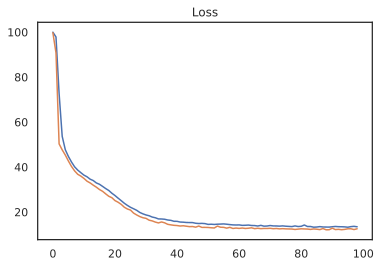

In [115]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [116]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [117]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(
    f"TEST mape: {(mape(y_test, (test_predict_nn2[:,0]//10000)*10000))*100:0.2f}%")

TEST mape: 12.66%


In [118]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('../working/nn2_submission.csv', index=False)

МАРЕ на тесте - 12.14%

МАРЕ на KAGGLE - 13.10505 (очень плохо)

# Добавляем картинки

### Data

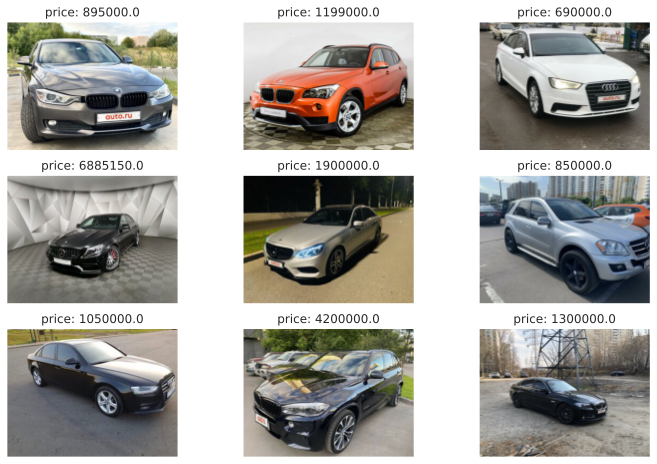

In [119]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [120]:
size = (320, 240)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data1['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

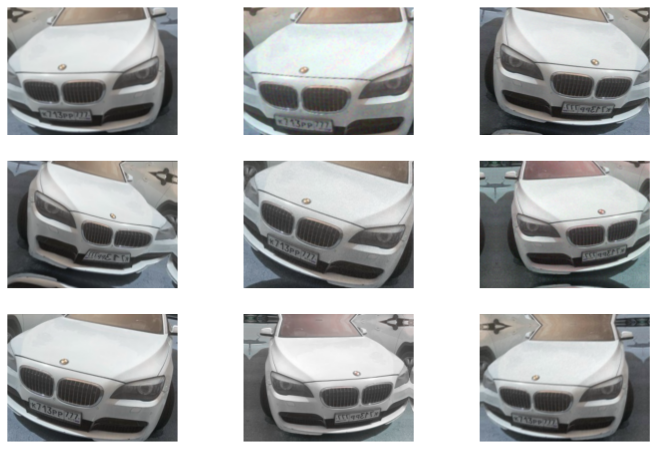

In [121]:
import albumentations as A
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


# пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
# пробовал аугментацию из предыдущего модуля, но отработала хуже
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
                     rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# пример аугментированных картинок
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [122]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [123]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data1.description)

In [124]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data1.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data1.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data1.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

### Строим сверточную сеть для анализа изображений без "головы"

Будем использовать пре-тренированную на imagenet сеть EfficientNetB7 (в предыдущей "курсовой" она показала хороший результат)

In [125]:
# нормализация включена в состав модели EfficientNetB7
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB7(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

258080768/258076736 [==============================] - 1s 0us/step


In [126]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
])

In [127]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
])

In [128]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [129]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [130]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE',
                              factor=0.25,
                              patience=2,
                              min_lr=0.00000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [131]:
history = model.fit(train_dataset.batch(16),
                    epochs=100,
                    validation_data=test_dataset.batch(16),
                    callbacks=callbacks_list
                    )

Epoch 1/100
355/355 [==============================] - 369s 1s/step - loss: 47.7228 - MAPE: 47.7228 - val_loss: 33.7436 - val_MAPE: 33.7436
Epoch 2/100
355/355 [==============================] - 362s 1s/step - loss: 32.1120 - MAPE: 32.1120 - val_loss: 26.2335 - val_MAPE: 26.2335
Epoch 3/100
355/355 [==============================] - 364s 1s/step - loss: 24.6217 - MAPE: 24.6217 - val_loss: 18.9890 - val_MAPE: 18.9890
Epoch 4/100
355/355 [==============================] - 364s 1s/step - loss: 20.1571 - MAPE: 20.1571 - val_loss: 16.0140 - val_MAPE: 16.0140
Epoch 5/100
355/355 [==============================] - 362s 1s/step - loss: 18.1051 - MAPE: 18.1051 - val_loss: 14.8894 - val_MAPE: 14.8894
Epoch 6/100
355/355 [==============================] - 363s 1s/step - loss: 17.0014 - MAPE: 17.0014 - val_loss: 15.4656 - val_MAPE: 15.4656
Epoch 7/100
355/355 [==============================] - 364s 1s/step - loss: 16.1227 - MAPE: 16.1227 - val_loss: 13.8318 - val_MAPE: 13.8318
Epoch 8/100
355/355 

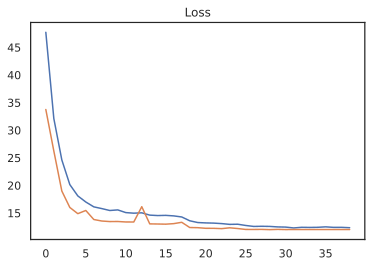

In [132]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [133]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [134]:
test_predict_nn3 = model.predict(test_dataset.batch(16))
print(
    f"TEST mape: {(mape(y_test, (test_predict_nn3[:,0]//10000)*10000))*100:0.2f}%")

TEST mape: 12.03%


In [135]:
# теперь предсказание на тестовом датасете
sub_predict_ftf = model.predict(sub_dataset.batch(16))
sample_submission['price'] = (sub_predict_ftf[:, 0]//10000)*10000
sample_submission.to_csv('../submit_pre_blend.csv', index=False)

# Blend

In [136]:
# Подгружаем для Блендинга ранее полученный и сохраненный сабмит после LightAutoML
autoML_submission = pd.read_csv('../input/alexeizh/autoML_submission.csv')

In [138]:
# делаем блендинг - смотрим результат
blend_sub_predict = (
    autoML_submission['price'].values + (sub_predict_ftf[:, 0]//10000)*10000) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

MAPE KAGGLE - 11.54 (!) 33-е место в leaderboard!!!


# Model Bonus: проброс признака

In [139]:
# # MLP
# model_mlp = Sequential()
# model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# model_mlp.add(L.Dropout(0.5))
# model_mlp.add(L.Dense(256, activation="relu"))
# model_mlp.add(L.Dropout(0.5))

In [140]:
# # FEATURE Input
# # Iput
# productiondate = L.Input(shape=[1], name="productiondate")
# # Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
# f_productiondate = L.Flatten()(emb_productiondate)

In [141]:
# combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# # being our regression head
# head = L.Dense(64, activation="relu")(combinedInput)
# head = L.Dense(1, activation="linear")(head)

# model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [142]:
# model.summary()

In [143]:
# optimizer = tf.keras.optimizers.Adam(0.01)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [144]:
# history = model.fit([X_train, X_train.productionDate.values], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([X_test, X_test.productionDate.values], y_test),
#                     callbacks=callbacks_list
#                    )

In [145]:
# model.load_weights('../working/best_model.hdf5')
# test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
# print(f"TEST mape: {(mape(y_test, (test_predict_nn_bonus[:,0]//10000)*10000))*100:0.2f}%")

MAPE - 13.86 (!) слишком много... НЕ буду применять проброс признака

# Выводы

### Что удалось сделать

1. Удалось сделать EDA и обнаружить влияние на цену марки машины, цвета, количества владельцев и т.п.
2. Удалось сравнить работу различных моделей (в том числе нейро-сети) для работы с табличными данными
3. Удалось провести обработку текста для работы NLP (убрав вводные слова, числительные, не кириллические символы и т.п., токенизировать текст)
4. Удалось сделать аугментацию картинок и отработать mutiple inputs модели
5. Удалось провести fine tuning финальной модели (по схеме - сначала обучаются все модели, кроме сверточной,
затем половина слоев сверточной модели, затем вся сверточная модель целиком), но это ухудшило разультат (11,83% МАРЕ вместо 11,54%)
6. Удалось провести блендинг (и он существенно улучшил результат)
7. Удалось сделать проброс признака (но он катастрофически ухудшил результат - до 13,8%)
8. Была попытка добавить полиномиальных признаков, но попытка ухудшила результат

### Что не удалось
1. Не удалось поэкспериментировать с fine-tuning (сделать другую последовательность в обучении и замораживании слоев и т.п.).
Не получилось это сделать просто в силу аппартаных ограничений. Просто не хватало времени на Kaggle, а на стороннем сервере,
где я всетаки смог реализовать одну из схем, просчет шел около 40 часов (!).
2. Не удалось поэкспериментировать с настройкой гипер-параметров моделей (опять же в силу аппаратных ограничений)
3. Не удалось попробовать обучение на фолдах (опять в силу аппаратных ограничений... с ужасом думаю сколько бы времени это заняло)